In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
import random
import os

import math

import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string
from sklearn.preprocessing import OneHotEncoder

# Read and process data

### Calculate the power and put it in a dataframe

In [2]:
def calculate_power(LF1V, LF1I, TimeTicks1, LF2V, LF2I, TimeTicks2):
    LF1V = np.array(LF1V)
    LF1I = np.array(LF1I)
    LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
    LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

    LF2V = np.array(LF2V)
    LF2I = np.array(LF2I)
    LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
    LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

    L1_P = LF1V * np.conjugate(LF1I)
    L2_P = LF2V * np.conjugate(LF2I)

    L1_ComplexPower = np.sum(L1_P, axis=1)
    L2_ComplexPower = np.sum(L2_P, axis=1)

    L1_real = np.real(L1_ComplexPower)
    L1_imag = np.imag(L1_ComplexPower)
    L1_app = np.abs(L1_ComplexPower)

    L2_real = np.real(L2_ComplexPower)
    L2_imag = np.imag(L2_ComplexPower)
    L2_app = np.abs(L2_ComplexPower)

    L1_Pf = np.cos(np.angle(L1_P[:, 0]))
    L2_Pf = np.cos(np.angle(L2_P[:, 0]))

    L1_actual_power = L1_real * L1_Pf
    L2_actual_power = L2_real * L2_Pf

    time_ticks1 = np.array(TimeTicks1)
    time_ticks2 = np.array(TimeTicks2)

    data = pd.DataFrame()
    len = min(L1_actual_power.size, L2_actual_power.size)

    data["Phase1_actual"] = L1_actual_power[:len]
    data["Phase1_real"] = L1_real[:len]
    data["Phase1_img"] = L1_imag[:len]
    data["Phase1_app"] = L1_app[:len]
    data["Phase1_time"] = time_ticks1[:len]

    data["Phase2_actual"] = L2_actual_power[:len]
    data["Phase2_real"] = L2_real[:len]
    data["Phase2_img"] = L2_imag[:len]
    data["Phase2_app"] = L2_app[:len]
    data["Phase2_time"] = time_ticks2[:len]

    return data

### Go through directory and process the days

In [3]:
# Directory is the path to the directory where to house's information is
def read_files_in_directory(directory):
    all_tagging_info = pd.DataFrame()
    labels = []
    data = []

    for root, _, files in os.walk(directory):
        if "Testing" in root:
            continue

        LF1I = pd.DataFrame()
        LF1V = pd.DataFrame()
        TimeTicks1 = pd.DataFrame()
        LF2I = pd.DataFrame()
        LF2V = pd.DataFrame()
        TimeTicks2 = pd.DataFrame()
        for file in files:

            file_path = os.path.join(root, file)
            if file == "CompleteTaggingInfo.csv":
                all_tagging_info = pd.read_csv(file_path)
                continue

            if file == "TaggingInfo.csv":
                # labels.append(pd.read_csv(file_path))
                continue

            if file == "LF1I.csv":
                LF1I = pd.read_csv(file_path)
                continue

            if file == "LF1V.csv":
                LF1V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks1.csv":
                TimeTicks1 = pd.read_csv(file_path)
                continue

            if file == "LF2I.csv":
                LF2I = pd.read_csv(file_path)
                continue

            if file == "LF2V.csv":
                LF2V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks2.csv":
                TimeTicks2 = pd.read_csv(file_path)
                continue

        if not LF1I.empty and not LF1V.empty and not LF2I.empty and not LF2V.empty:
            print(f"{root}: ")
            day_data = calculate_power(LF1I, LF1V, TimeTicks1, LF2I, LF2V, TimeTicks2)
            data.append(day_data)

    return data, labels, all_tagging_info

In [4]:
data, _, all_tagging_info = read_files_in_directory(r".\dataset\H1")

.\dataset\H1\Tagged_Training_04_13_1334300401: 
.\dataset\H1\Tagged_Training_10_22_1350889201: 
.\dataset\H1\Tagged_Training_10_23_1350975601: 
.\dataset\H1\Tagged_Training_10_24_1351062001: 
.\dataset\H1\Tagged_Training_10_25_1351148401: 
.\dataset\H1\Tagged_Training_12_27_1356595201: 


In [5]:
print(data)

[        Phase1_actual  Phase1_real  Phase1_img  Phase1_app   Phase1_time  \
0           19.430857    24.264125   18.475752   30.497560  1.334300e+09   
1           19.924720    24.357135   17.474827   29.977318  1.334300e+09   
2           19.690603    24.166927   17.523352   29.851436  1.334300e+09   
3           19.910825    24.234800   17.153411   29.691161  1.334300e+09   
4           20.829979    25.187723   17.446867   30.640081  1.334300e+09   
...               ...          ...         ...         ...           ...   
518938      19.939808    24.472770   17.732765   30.221969  1.334387e+09   
518939      19.792885    24.371436   17.809936   30.185439  1.334387e+09   
518940      20.446493    24.783498   17.294649   30.221295  1.334387e+09   
518941      20.235556    24.840667   18.001915   30.677804  1.334387e+09   
518942      19.618725    24.178684   17.711506   29.971757  1.334387e+09   

        Phase2_actual  Phase2_real  Phase2_img  Phase2_app   Phase2_time  
0          

# Next we need to detect all labeled events

### All the methods needed to detect, filter and extract spikes

In [27]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg

def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

def detect_cusum(array, threshold, drift):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index_start = np.array([[], [], []], dtype=int)
    event_index_end = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i-1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i-1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i-1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold:
            event_index_start = np.append(event_index_start, i)
            sum_positive[i], sum_negative[i] = 0, 0
            continue

        if sum_negative[i] > threshold:
            event_index_end = np.append(event_index_end, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index_start, event_index_end

def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, event_indices.size):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)

# Short spikes in power when an appliance starts up can be detected as an end event, so make sure that start and end events are not too close together
def filter_spikes(events_start, events_end, min_separation):
    indexes_to_delete = list()

    for iter in range(4):
        for i in range(events_start.size):
            for j in range(events_end.size):
                if events_end[j] < events_start[i]:
                    continue

                if events_end[j] - events_start[i] < min_separation:
                    indexes_to_delete.append(j)
                    break

                break

        events_end = np.delete(events_end, indexes_to_delete)
        indexes_to_delete = list()
    return events_end

def group_start_end(events_start, events_end):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        for j in range(events_end.size):
            if events_end[j] < events_start[i]:
                continue

            start_indexes.append(events_start[i])
            end_indexes.append(events_end[j])
            break

    return np.array(start_indexes), np.array(end_indexes)

def filter_short_events(events_start, events_end, min_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        if events_end[i] - events_start[i] >= min_event_length:
            start_indexes.append(events_start[i])
            end_indexes.append(events_end[i])

    return np.array(start_indexes), np.array(end_indexes)

def calculate_overlap(start, end, on, off):
    return (min(end, off) - max(start, on)) / (end - start)

def find_closest_event(events_start, events_end, time_ticks, label):
    start = 0
    end = max(events_end)

    for event in range(events_start.size):
        if events_start[event] > start and time_ticks[int(events_start[event])] <= label["OnTime"]:
            start = events_start[event]

        if events_end[event] < end and time_ticks[int(events_end[event])] >= label["OffTime"]:
            end = events_end[event]

    return start, end

def extract_labeled_spikes(events_start, events_end, time_ticks, labels):
    labeled_events_start = list()
    labeled_events_end = list()
    event_labels = list()
    marker = 0
    phase_index = 0

    start_of_day = time_ticks[0][0]
    end_of_day = time_ticks[0][time_ticks[0].size - 1]

    for index in range(labels.shape[0]):
        row = labels.iloc[index]
        found = False

        if not (start_of_day <= row["OnTime"] <= end_of_day):
            continue

        last_event = 0
        phase_index = 0
        for event in range(events_start.size):
            start = int(events_start[event])
            end = int(events_end[event])

            if start < last_event:
                phase_index += 1

            last_event = start

            time = time_ticks[phase_index]

            if not (row["OnTime"] <= time[start] <= row["OffTime"] or row["OnTime"] <= time[end] <= row["OffTime"]):
                continue

            found = True
            overlap = calculate_overlap(time[start], time[end], row["OnTime"], row["OffTime"])
            if overlap < 0.3:
                continue

            labeled_events_start.append(start)
            labeled_events_end.append(end)
            event_labels.append(row["ID"])

            if phase_index == 0:
                marker += 1

        if not found:
            start, end = find_closest_event(events_start, events_end, time_ticks[phase_index], row)
            labeled_events_start.append(start)
            labeled_events_end.append(end)
            event_labels.append(row["ID"])

            if phase_index == 0:
                marker += 1

    return np.array(labeled_events_start), np.array(labeled_events_end), np.array(event_labels), marker

def calculate_events(phase_power):
    phase_power = moving_average(phase_power, 7)
    phase_power = normalize(phase_power)

    events_start, events_end = detect_cusum(phase_power, threshold=0.009, drift=0.0005)
    events_start = filter_close_events(events_start, 60)
    events_end = filter_close_events(events_end, 60)
    events_end = filter_spikes(events_start, events_end, 12)
    events_start, events_end = group_start_end(events_start, events_end)
    events_start, events_end = filter_short_events(events_start, events_end, 100)

    return events_start, events_end

def remove_overlapping_events(events_start, events_end, event_labels, marker):
    to_remove = list()
    new_marker = marker

    for index in range(1, events_start.size):
        if events_end[index] == events_end[index - 1]:
            if index < marker:
                new_marker -= 1
            to_remove.append(index)

    return np.delete(events_start, to_remove), np.delete(events_end, to_remove), np.delete(event_labels, to_remove), new_marker

In [41]:
def label_generalization(ids, general_labels):
    generalized_ids = np.empty(0)
    for id in ids:
        generalized_ids = np.append(generalized_ids, general_labels.loc[general_labels['ApplianceID'] == id, 'GeneralID'].unique()[0])
    return generalized_ids

def detect_day_events(dataframe, labels, general_tagging_info):
    phases = ["Phase1", "Phase2"]
    events_start = np.empty(0)
    events_end = np.empty(0)
    time_ticks = np.empty((2, len(dataframe)))
    i = 0

    for phase in phases:
        dataframe[phase + "_events"] = 0
        power = dataframe[phase + "_actual"]
        time = dataframe[phase + "_time"]

        events_start_temp, events_end_temp = calculate_events(power)
        events_start = np.append(events_start, events_start_temp)
        events_end = np.append(events_end, events_end_temp)
        time_ticks[i] = time
        i += 1


    events_start, events_end, event_labels, marker = extract_labeled_spikes(events_start, events_end, time_ticks, labels)
    events_start, events_end, event_labels, marker = remove_overlapping_events(events_start, events_end, event_labels, marker)
    event_labels = label_generalization(event_labels, general_tagging_info)

    marker -= 1
    phase = "Phase1"
    for index in range(events_start.size):
        if index == marker:
            phase = "Phase2"

        event = [events_start[index], events_end[index]]
        dataframe.loc[event, phase + "_events"] = event_labels[index]

    return dataframe

### Edit dataframes to have events

In [42]:
general_labels = pd.read_csv(r".\dataset\AllTaggingInfo_generalized.csv")
for index in range(len(data)):
    data[index] = detect_day_events(data[index], all_tagging_info, general_labels)

In [45]:
for thing in data[0]["Phase1_events"]:
    if thing != 0:
        print(thing)

10
10
8
8
11
11
11
11


# Now we need to process the data, so that it's in a format that we can give to the model


In [4]:
def encode(label, total_labels):
    array = np.zeros(total_labels)
    array[label - 1] = 1
    return array

def format_data(power, time_ticks, labels, window):
    data = np.empty((len(power) // window, window))
    appliances = np.empty((len(power) // window, max(labels["ApplianceID"])))
    time = np.empty((len(power) // window, window))
    last_entry_index = 0

    for index in range(0, len(power) - window + 1, window):
        window_start = index
        window_end = index + window

        found = False
        for label in labels.iterrows():
            label = label[1]
            start_time = time_ticks[window_start].item()
            end_time = time_ticks[window_end].item()

            if label["ON_Time"] <= start_time <= label["OFF_Time"] or label["ON_Time"] <= end_time <= label["OFF_Time"]:
                found = True
                data[last_entry_index] = power[window_start:window_end]
                time[last_entry_index] = time_ticks[window_start:window_end]
                appliances[last_entry_index] = encode(label["ApplianceID"], max(labels["ApplianceID"]))
                last_entry_index += 1
                break

        # if not found:
        #     chance = random.random()
        #     if chance > 0.99:
        #         data[last_entry_index] = power[window_start:window_end].reshape(window)
        #         time[last_entry_index] = time_ticks[window_start:window_end].reshape(window)
        #         appliances[last_entry_index] = encode(0, max(labels["ApplianceID"]))
        #         last_entry_index += 1

    return data[:last_entry_index], time[:last_entry_index], appliances[:last_entry_index]

In [5]:
training_data = np.zeros((1, 50))
time = np.zeros((1, 50))
appliances = np.zeros((1, 38))

for datapoint in data:
    training_datapoint, time_datapoint, appliances_datapoint = format_data(datapoint["Power"], datapoint["TimeTicks1"], labels[0], 50)
    print(training_data)
    print(training_datapoint)
    training_data = np.concatenate((training_data, training_datapoint))
    time = np.concatenate((time, time_datapoint))
    appliances = np.concatenate((appliances, appliances_datapoint))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[[ 164.12239075  163.80583808  163.51621994 ...  162.67355358
   163.75977397  163.31434473]
 [ 163.24203754  163.75698196  163.26117224 ...  162.96452658
   162.89113609  163.24454919]
 [ 162.37752987  163.21373146  164.06082511 ...  181.8292661
   181.25494634  182.11446942]
 ...
 [ 114.04577603  114.60402723  113.56134062 ... 1899.4393204
  1729.91403456 1633.60022889]
 [1571.3892606  1530.99310597 1506.91533011 ... 1440.47388715
  1436.23576779 1433.82841702]
 [1433.41184793 1432.09137346 1428.90118001 ... 1397.31581857
  1399.50585291 1399.54308391]]
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [ 164.12239075  163.80583808  163.51621994 ...  162.67355358
   163.75977397  163.31434473]
 [ 163.24203754  163.75698196  163.26117224 ...  162.96452658
   162.89113609  163.24454919]
 ...
 [ 1

In [6]:
processed_data = np.delete(training_data, 0, axis=0)
processed_time = np.delete(time, 0, axis=0)
processed_labels = np.delete(appliances, 0, axis=0)

In [7]:
#normalize the data
max = 0
for index in range(len(processed_data)):
    for entry in range(len(processed_data[index])):
        if processed_data[index][entry] > max:
            max = processed_data[index][entry]

for index in range(len(processed_data)):
    for entry in range(len(processed_data[index])):
        processed_data[index][entry] = processed_data[index][entry] / max

### Combine power measurements and time

In [8]:
data_with_time = np.concatenate((processed_data, processed_time), axis=1)

### Build the model

In [10]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(50, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(38, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [86]:
model = Sequential()
model.add(InputLayer(input_shape=(10,)))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(39, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Train the model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels)

In [12]:
model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/500
29/29 [==============================] - 2s 19ms/step - loss: 2.7595 - accuracy: 0.5267 - val_loss: 2.2056 - val_accuracy: 0.5509
Epoch 2/500
29/29 [==============================] - 0s 12ms/step - loss: 1.9983 - accuracy: 0.5579 - val_loss: 2.0452 - val_accuracy: 0.5509
Epoch 3/500
29/29 [==============================] - 0s 13ms/step - loss: 1.9089 - accuracy: 0.5579 - val_loss: 2.0247 - val_accuracy: 0.5509
Epoch 4/500
29/29 [==============================] - 0s 13ms/step - loss: 1.8798 - accuracy: 0.5579 - val_loss: 1.9873 - val_accuracy: 0.5509
Epoch 5/500
29/29 [==============================] - 0s 12ms/step - loss: 1.8265 - accuracy: 0.5579 - val_loss: 1.9378 - val_accuracy: 0.5509
Epoch 6/500
29/29 [==============================] - 0s 12ms/step - loss: 1.7835 - accuracy: 0.5596 - val_loss: 1.8519 - val_accuracy: 0.5543
Epoch 7/500
29/29 [==============================] - 0s 12ms/step - loss: 1.7351 - accuracy: 0.5568 - val_loss: 1.8356 - val_accuracy: 0.5509
Epoch 

## Visualise data

In [13]:
file_path_volts1 = r".\dataset\H1\Testing_07_09_1341817201\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Testing_07_09_1341817201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Testing_07_09_1341817201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Testing_07_09_1341817201\LF2V.csv"
file_path_amps2 = r".\dataset\H1\Testing_07_09_1341817201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H1\Testing_07_09_1341817201\TimeTicks2.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

In [14]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [15]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [16]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

In [17]:
print(TS1_real[0])
print(TS1_real[len(TS1_real) - 1])

print(TS2_real[0])
print(TS2_real[len(TS1_real) - 1])

2012-07-09T07:00:01.325629696
2012-07-10T06:59:58.839011328
2012-07-09T07:00:01.238788352
2012-07-10T06:59:58.037620224


In [27]:
labels["ON_Time"] = pd.to_datetime(labels["ON_Time"], unit='s')
labels["OFF_Time"] = pd.to_datetime(labels["OFF_Time"], unit='s')

TypeError: list indices must be integers or slices, not str

In [18]:
labels.head(1000)

AttributeError: 'list' object has no attribute 'head'

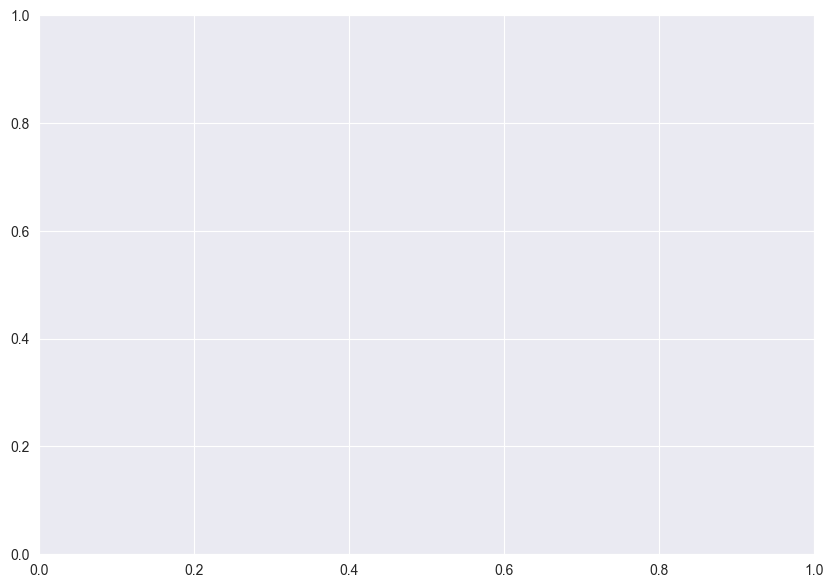

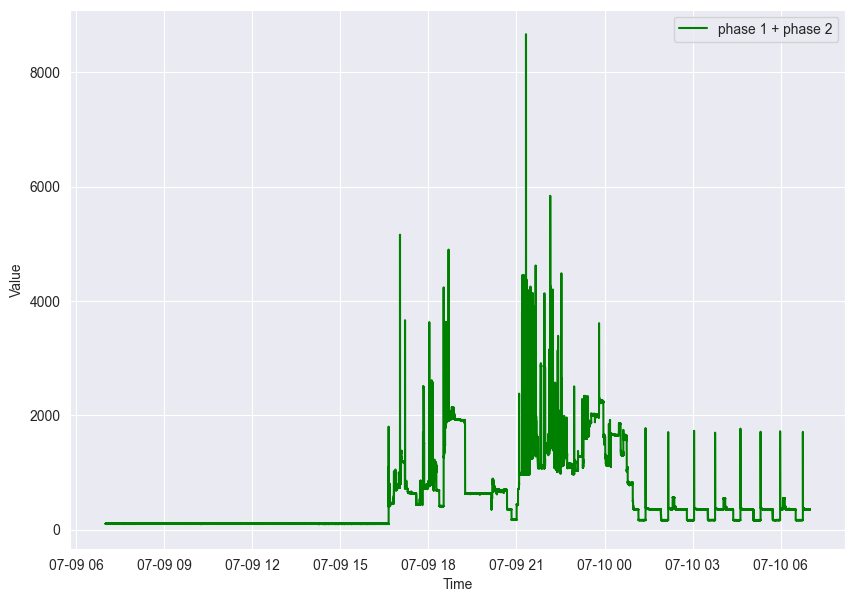

In [37]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index


start_index, end_index = zoomIn("2013-02-15 18:45:00", "2013-02-15 18:55:00", time_ticks1_np)
plt.figure(figsize=(10, 7))

#This plots total power consumption (zoomed in)
# plt.plot(TS2_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='g', label='phase 1 + phase 2')

#This plots total power consumption
plt.plot(TS1_real, power, linestyle='-', color='g', label='phase 1 + phase 2')

# This plots phase 1 and phase 2 separately (zoomed in)
# plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
# plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

# This plots phase 1 and phase 2 separately (whole thing)
# plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
# plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
window = 50
data_to_classify = np.empty((len(power) // window, window))
last_entry_index = 0
for index in range(0, len(power) - window + 1, window):
        window_start = index
        window_end = index + window
        data_to_classify[last_entry_index] = power[window_start:window_end]
        last_entry_index += 1

10378


In [21]:
predictions = np.empty((len(power) // window, 38))
for index in range(len(data_to_classify)):
    print(data_to_classify[index].shape)
    predictions[index] = model.predict(data_to_classify[index].reshape(1, window, 1))

print(predictions[0])
predicted_label = np.argmax(predictions)
print(predicted_label)

(50,)
1/1 [==============================] - 0s 83ms/step
(50,)
1/1 [==============================] - 0s 16ms/step
(50,)
1/1 [==============================] - 0s 11ms/step
(50,)
1/1 [==============================] - 0s 15ms/step
(50,)
1/1 [==============================] - 0s 14ms/step
(50,)
1/1 [==============================] - 0s 16ms/step
(50,)
1/1 [==============================] - 0s 19ms/step
(50,)
1/1 [==============================] - 0s 20ms/step
(50,)
1/1 [==============================] - 0s 16ms/step
(50,)
1/1 [==============================] - 0s 10ms/step
(50,)
1/1 [==============================] - 0s 16ms/step
(50,)
1/1 [==============================] - 0s 19ms/step
(50,)
1/1 [==============================] - 0s 20ms/step
(50,)
1/1 [==============================] - 0s 26ms/step
(50,)
1/1 [==============================] - 0s 17ms/step
(50,)
1/1 [==============================] - 0s 14ms/step
(50,)
1/1 [==============================] - 0s 16ms/step
(50,)
1/1 [===

In [33]:
# Reshape X_test to match the model's input shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 50, 1)

# Now, you can use model.predict() on the reshaped X_test data
predictions = model.predict(data_to_classify.reshape(data_to_classify.shape[0], 50, 1))

# Find the class with the highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class as an integer
for i, predicted_class in enumerate(predicted_classes):
    print(f"Prediction {i + 1}: Class {predicted_class}")

325/325 [==============================] - 1s 2ms/step
Prediction 1: Class 10
Prediction 2: Class 10
Prediction 3: Class 10
Prediction 4: Class 10
Prediction 5: Class 10
Prediction 6: Class 10
Prediction 7: Class 10
Prediction 8: Class 10
Prediction 9: Class 10
Prediction 10: Class 10
Prediction 11: Class 10
Prediction 12: Class 10
Prediction 13: Class 10
Prediction 14: Class 10
Prediction 15: Class 10
Prediction 16: Class 10
Prediction 17: Class 10
Prediction 18: Class 10
Prediction 19: Class 10
Prediction 20: Class 10
Prediction 21: Class 10
Prediction 22: Class 10
Prediction 23: Class 10
Prediction 24: Class 10
Prediction 25: Class 10
Prediction 26: Class 10
Prediction 27: Class 10
Prediction 28: Class 10
Prediction 29: Class 10
Prediction 30: Class 10
Prediction 31: Class 10
Prediction 32: Class 10
Prediction 33: Class 10
Prediction 34: Class 10
Prediction 35: Class 10
Prediction 36: Class 10
Prediction 37: Class 10
Prediction 38: Class 10
Prediction 39: Class 10
Prediction 40: Cla

In [43]:
print(data)
print(appliances.shape)

[[227.01128249 226.97864164 229.18759796 ... 227.36862706 226.51124187
  229.0585733 ]
 [233.88943465 227.0682311  226.624764   ... 228.01646653 228.07221639
  227.07364906]
 [226.7405476  229.17390162 227.57545939 ... 229.80850454 227.61660306
  227.27179919]
 ...
 [257.82555045 256.37532101 254.0490028  ... 247.44726288 255.30634211
  255.72174899]
 [253.18286489 258.52368351 250.83950772 ... 249.56506619 248.14645594
  247.17518501]
 [247.51432482 247.69578722 253.49514395 ... 245.26098514 245.16106357
  252.73071368]]
(1545, 38)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, appliances)
print(X_train)
print(y_train)

[[1169.59068747 1173.06503406 1168.25841473 ... 1169.4250345
  1167.91739477 1167.81830915]
 [1347.63535086 1342.86682073 1344.85626716 ... 1342.98060145
  1343.95337127 1341.7469311 ]
 [ 234.6962654   235.18923433  235.14923044 ...  239.99873544
   234.8488575   228.01369362]
 ...
 [ 231.56137215  235.89275541  238.06208049 ...  235.94101108
   236.60048765  234.46935943]
 [ 226.4378199   227.23576958  228.9738267  ...  228.48407752
   228.78074519  230.62463554]
 [ 248.26781285  248.03429699  244.04835821 ...  246.85250753
   246.30576173  245.75636026]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
count = 0
for index in range(len(appliances)):
    if appliances[index][0] != 1:
        count += 1

print(count)

1545


In [54]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(10, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(38, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
model.fit(X_train, y_train, epochs=500, batch_size=48, validation_data=(X_test, y_test))

Epoch 1/500
25/25 [==============================] - 0s 8ms/step - loss: 0.8365 - accuracy: 0.6900 - val_loss: 3.2745 - val_accuracy: 0.5866
Epoch 2/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7467 - accuracy: 0.7202 - val_loss: 3.2043 - val_accuracy: 0.6796
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7233 - accuracy: 0.7314 - val_loss: 3.2729 - val_accuracy: 0.6382
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7176 - accuracy: 0.7280 - val_loss: 3.3531 - val_accuracy: 0.6744
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7283 - accuracy: 0.7306 - val_loss: 3.3349 - val_accuracy: 0.6408
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7550 - accuracy: 0.7142 - val_loss: 3.2759 - val_accuracy: 0.6434
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.7366 - val_loss: 3.4485 - val_accuracy: 0.6563
Epoch 8/500
2

In [57]:
# Reshape X_test to match the model's input shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 10, 1)

# Now, you can use model.predict() on the reshaped X_test data
predictions = model.predict(X_test_reshaped)

# Find the class with the highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class as an integer
for i, predicted_class in enumerate(predicted_classes):
    print(f"Prediction {i + 1}: Class {predicted_class}")

13/13 [==============================] - 0s 1ms/step
Prediction 1: Class 18
Prediction 2: Class 5
Prediction 3: Class 6
Prediction 4: Class 5
Prediction 5: Class 5
Prediction 6: Class 29
Prediction 7: Class 7
Prediction 8: Class 8
Prediction 9: Class 18
Prediction 10: Class 6
Prediction 11: Class 33
Prediction 12: Class 6
Prediction 13: Class 5
Prediction 14: Class 29
Prediction 15: Class 18
Prediction 16: Class 21
Prediction 17: Class 5
Prediction 18: Class 5
Prediction 19: Class 29
Prediction 20: Class 32
Prediction 21: Class 5
Prediction 22: Class 5
Prediction 23: Class 7
Prediction 24: Class 7
Prediction 25: Class 18
Prediction 26: Class 21
Prediction 27: Class 5
Prediction 28: Class 29
Prediction 29: Class 5
Prediction 30: Class 5
Prediction 31: Class 18
Prediction 32: Class 5
Prediction 33: Class 18
Prediction 34: Class 6
Prediction 35: Class 21
Prediction 36: Class 18
Prediction 37: Class 6
Prediction 38: Class 18
Prediction 39: Class 18
Prediction 40: Class 7
Prediction 41: Cla